In [1]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [2]:
# this block is used for copying/moving files
import os
import shutil
#shutil.copyfile('src', 'dst')
#shutil.move

# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/scrape/bin/python'

In [32]:
# This is a python module with dictionaries of states and countries; it also contains three functions repair_dict, reverse_dict, and custom_list
import state_country_dicts as scd

In [33]:
# provides ability to reload modules (wihtout leaving jupyter) if changes are made
# import importlib
# importlib.reload(scd)

In [34]:
import numpy as np
import pandas as pd

In [35]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

#import dateutil.parser
import time

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Cornavirus section

In [36]:
# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-04-12'

### Moves all files from covid_data_update to covid_data 

In [37]:
# House keeping covid_data_update folder
# prepare move of all files from covid_data_update to covid_data 
# so that we are left with an empty covid_date_update folder
file_names = []
source_dir = 'covid_data_update'
target_dir = 'covid_data'
print("covid_data_update directory contents:") 

file_names = os.listdir(source_dir)
print (file_names)
if file_names == []:
    print ('Directory is empty so no files available to move')

covid_data_update directory contents:
[]
Directory is empty so no files available to move


In [52]:
# The below cell will archive all files in covid_data_update to covid_data

In [38]:
%%capture
# Move contents of source ('covid_data_update')to target ('covid_data')
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [39]:
def clean_up (number_str):
    '''This is a clean up routine so that only numeric characters remain'''
    number_str = number_str.replace(',', '').rstrip(']').lstrip("'")
    return int(number_str)

### Custom state dictionaries

In [43]:
# creates a custom state dict
s_string = input('Enter state codes seperated by a space:') or 'ca tx fl az co ny il'
print()

slist = scd.custom_list (s_string)
state_dict = {key: value for key, value in scd.all_states.items() if value in slist}
state_dict

Enter state codes seperated by a space: ca


{'california': 'CA'}

### State Scraping section

In [44]:
# The start dates for U.S.states and for countries are different so must be accounted for
st_start = pd.Timestamp('2020/3/13')
c_start = pd.Timestamp('2020/2/16')

# set end time to yesterday
end = pd.Timestamp.today() - pd.Timedelta(days=1)

# set the index to the appropriate date range for states and countries
st_index = pd.date_range(st_start, end)
c_index = pd.date_range(c_start, end)
len(st_index)
len(c_index)

# list comprehension to extract just the state initials from the dict
st_list = list(state_dict.values())

# create an empty pandas df with column headers from state_dict
state = pd.DataFrame(columns = st_list,index=st_index)
state.tail()

395

421

,CA
2021-04-07,NaN
2021-04-08,NaN
2021-04-09,NaN
2021-04-10,NaN
2021-04-11,NaN


In [45]:
state_url='https://www.worldometers.info/coronavirus/usa/'
# Here the keys are the state names and the values are the 2-letter abbreviation
for key, value in state_dict.items():
    url = state_url+key

    # scrape web page for state info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break
    

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    #state_previous_cases is a list of daily new coronavirus cases
    state_previous_cases = mo.group().split(',')[1:]
        
    len(state_previous_cases)

    # merge states into the existing df and apply the function clean_up to convert strings to ints
    # state[value] where value is the 2-letter abreviation
    state[value] = state_previous_cases
    state[value] = state[value].apply(clean_up)
    
    time.sleep(2)
state.tail()    

395

,CA
2021-04-07,2402
2021-04-08,2566
2021-04-09,3609
2021-04-10,3115
2021-04-11,3512


In [46]:
def list2string(l): 
    ''' This creates a a short string of state/country names 
    used during file save
    '''
    str1 = "_" 
    # return string  
    return (str1.join(l))

States available: ['CA']



Choose state for rolling averge: 


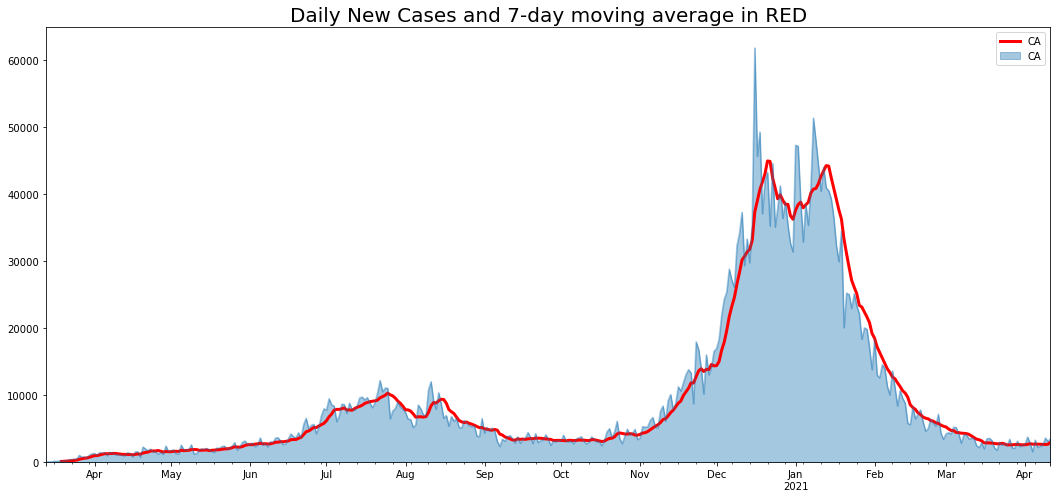

In [47]:
# Allows user to select state for rolling average 
s_available = list(state.columns)
print(f'States available: {s_available}')
print()

snames = (list2string(s_available))

select_state = input('Choose state for rolling averge:')or s_available[0]
select_state = select_state.upper()

if select_state not in s_available:
    select_state = s_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = state.loc[:,[select_state]].rolling(window=7).mean()

roll_data.plot(ax=ax, linewidth=3, color='r')
state.plot(kind='area',alpha=.4,ax=ax,stacked=False);
plt.title('Daily New Cases and 7-day moving average in RED', fontsize=20) 

#ax.set_title('Daily New Cases and 7-day moving average in RED', fontsize=20) 
plt.savefig(f'./covid_data_update/us_{day}.png');

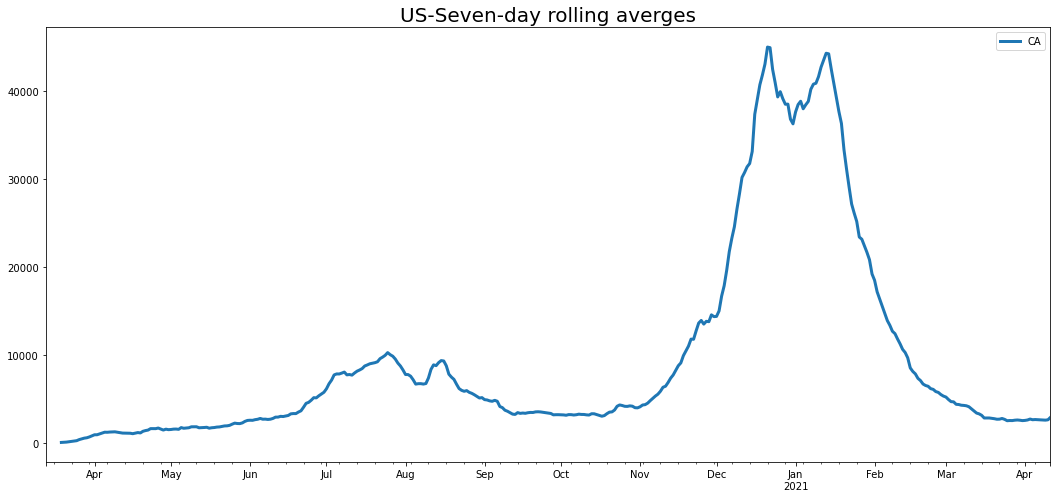

In [48]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges',fontsize=20)
plt.savefig(f'./covid_data_update/us_rolling_avg_{day}.png');

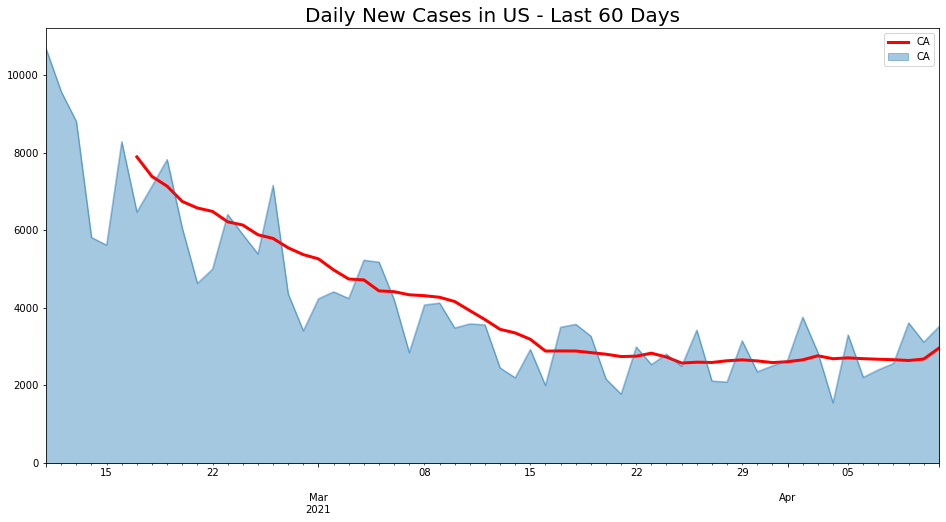

In [49]:
# Plot Last 60 Days
plt.close('all')
# Select last 60 days only
state_last60 = state.tail(60)

roll_data = state_last60.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last60.plot(kind='area',alpha=.4,ax=ax,stacked=False);

plt.title('Daily New Cases in US - Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_60_days_{day}.png');

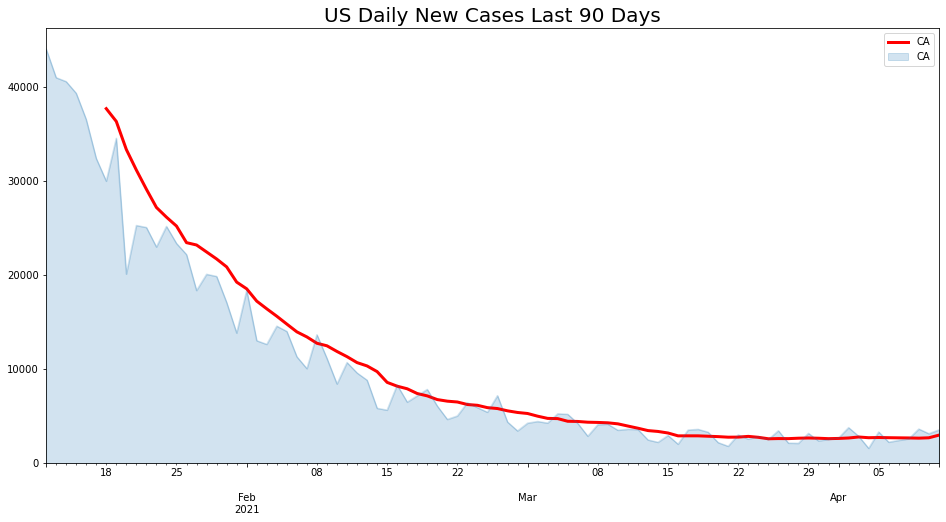

In [50]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
state_last90 = state.tail(90)

roll_data = state_last90.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('US Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_90_days_{day}.png');

In [51]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
state.sort_index(ascending = False)

,CA
2021-04-11,3512
2021-04-10,3115
2021-04-09,3609
2021-04-08,2566
2021-04-07,2402
2021-04-06,2209
2021-04-05,3300
2021-04-04,1552
2021-04-03,2849
2021-04-02,3758


### Custom country dictionaries

In [21]:
# creates a custom country dict
c_string = input('Enter country codes seperated by a space:') or 'fr it es uk de'
clist = scd.custom_list (c_string)

country_dict = {key: value for key, value in scd.all_countries.items() if value in clist}
print(country_dict)

print()

Enter country codes seperated by a space: uk it


{'uk': 'UK', 'italy': 'IT'}



### Scraping section

In [22]:
c_list = list(country_dict.values())
c_list

# create an empty pandas df with column headers from country_dict, using the starting dates for the country as index
country = pd.DataFrame(columns = c_list,index=c_index)
country.tail()

base_url='https://www.worldometers.info/coronavirus/country/'
# Here the keys are the country names and the values are the 2-letter abbreviation
for key, value in country_dict.items():
    url = base_url+key
    print(url)

    # scrape web page for country info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    #print(response.text[:400])
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    dat = soup.find(text=re_graph)
   
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    country_previous_cases = mo.group().split(',')[1:]
    #print(country_previous_cases)
    previous_cases = ["0" if i == 'null' else i for i in country_previous_cases]
    
    len(previous_cases)

    # merge countries into the existing df and apply the function clean_up to convert strings to ints
    country[value] = previous_cases
    country[value] = country[value].apply(clean_up)
    
    time.sleep(2)
country.clip(lower=0,inplace=True) #large negative number removed for better graphic clarity
country.tail()

['UK', 'IT']

,UK,IT
2021-04-06,NaN,NaN
2021-04-07,NaN,NaN
2021-04-08,NaN,NaN
2021-04-09,NaN,NaN
2021-04-10,NaN,NaN


https://www.worldometers.info/coronavirus/country/uk


420

https://www.worldometers.info/coronavirus/country/italy


420

,UK,IT
2021-04-06,2374,7745
2021-04-07,2758,13696
2021-04-08,3023,17207
2021-04-09,3145,18922
2021-04-10,2589,17558


Countries available: ['UK', 'IT']



Choose country for rolling averge: 


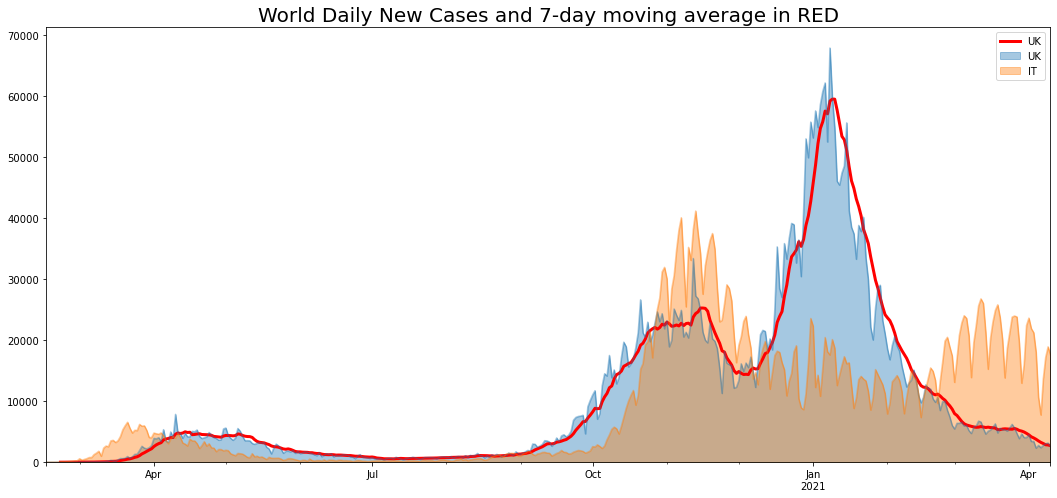

In [24]:
# Allows user to select the country for the rolling average
c_available = list(country.columns)
print(f'Countries available: {c_available}')
print()

snames = (list2string(c_available))

select_country = input('Choose country for rolling averge:') or c_available[0]
select_country = select_country.upper()

if select_country not in c_available:
    select_country = c_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = country.loc[:,[select_country]].rolling(window=7).mean()


roll_data.plot(ax=ax, linewidth=3, color='r')
country.plot(kind='area',alpha=.4,ax=ax,stacked=False)
plt.title('World Daily New Cases and 7-day moving average in RED',fontsize=20);
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_{day}.png');

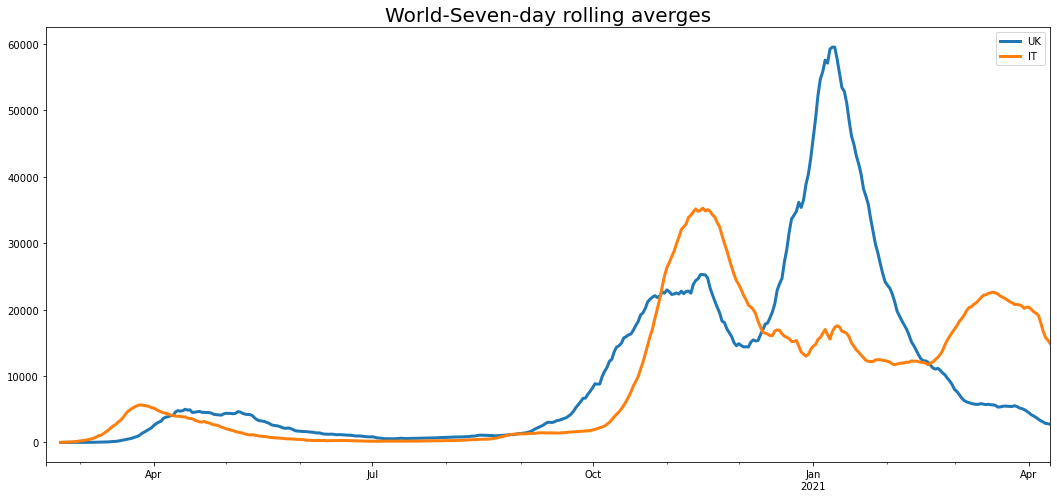

In [25]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = country.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges',fontsize=20)
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_rolling_avg_{day}.png');

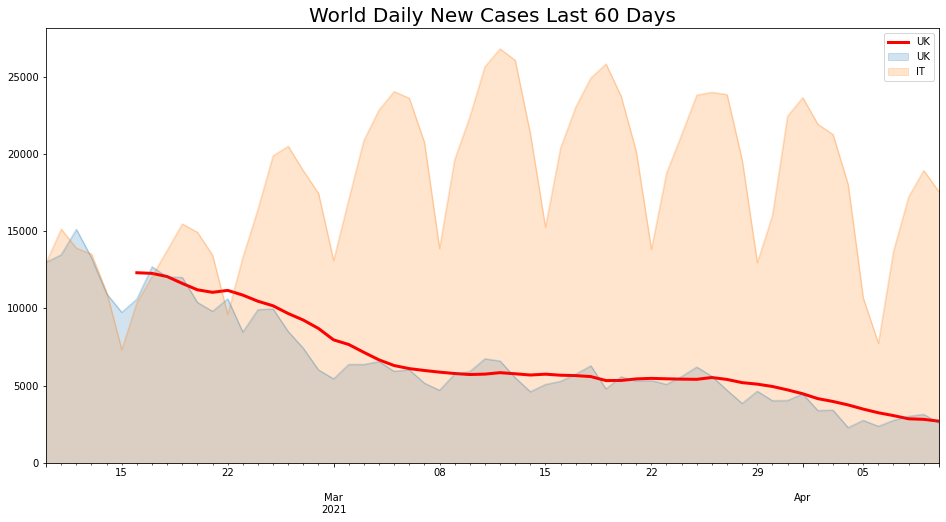

In [26]:
# Plot last 60 days
plt.close('all')
# Select last 60 days only
country_last60 = country.tail(60)

roll_data = country_last60.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last60.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_60_days_{day}.png');


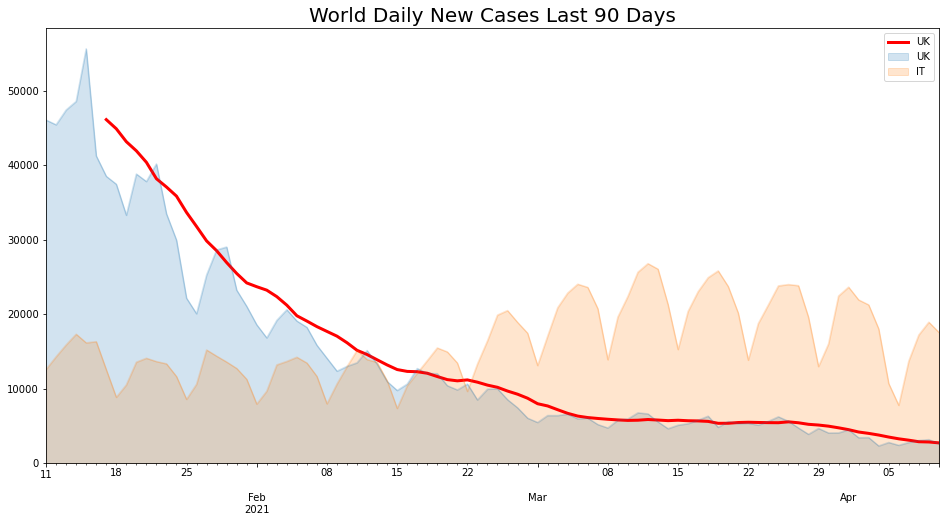

In [27]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
country_last90 = country.tail(90)

roll_data = country_last90.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_90_days_{day}.png');


In [28]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
country.sort_index(ascending = False)

,UK,IT
2021-04-10,2589,17558
2021-04-09,3145,18922
2021-04-08,3023,17207
2021-04-07,2758,13696
2021-04-06,2374,7745
2021-04-05,2757,10676
2021-04-04,2293,18025
2021-04-03,3417,21253
2021-04-02,3396,21918
2021-04-01,4470,23634


### Save merged dataframes to csv

In [29]:
# Merge state and country dfs into one
world = state.merge(country,left_index=True,right_index=True,how='outer')
world = world.fillna(0).astype(int)

In [30]:
# Sorting the table with recent dates on the top
world_table = world.sort_index(ascending = False)

# Save to csv by uncommenting out the next line
# world_table.to_csv(f'./covid_data/world_table{day}.csv')
world_table.head(5)

,FL,IL,MI,UK,IT
2021-04-10,6906,3630,7539,2589,17558
2021-04-09,7121,4004,8834,3145,18922
2021-04-08,7939,3739,8539,3023,17207
2021-04-07,5885,3790,9369,2758,13696
2021-04-06,5556,2931,6149,2374,7745


In [31]:
# Note that the last week may be only a partial unless this is executed at end of week
df = world.resample('w').sum()
df.tail(10)

,FL,IL,MI,UK,IT
2021-02-07,56606,20040,10578,128269,83705
2021-02-14,49390,15813,7933,92228,85135
2021-02-21,41399,12255,7416,77290,87361
2021-02-28,40449,12287,9384,60932,116024
2021-03-07,35774,11639,10731,41889,142209
2021-03-14,31813,10996,14789,39845,155661
2021-03-21,31541,12532,21952,38074,153239
2021-03-28,35656,15965,34365,36393,145010
2021-04-04,37821,18806,46114,26299,136223
2021-04-11,36887,20196,45971,16646,85804
